## Imports and data

In [0]:
! pip install --upgrade nltk
! pip install tldextract
import requests
#from empath import Empath
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import zipfile
import random
from matplotlib import pyplot
from scipy import stats
import bs4
import nltk
#nltk.download('all')
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline
import tldextract
import matplotlib.pyplot as plt

     |████████████████████████████████| 1.5MB 4.6MB/s 
  Created wheel for nltk: filename=nltk-3.4.5-cp36-none-any.whl size=1449908 sha256=d98383ac17be3e3cd0a898f4926c8e89fb34d942faa34cd0231f8a4aaf163eca
  Stored in directory: /root/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
     |████████████████████████████████| 51kB 2.6MB/s 


In [0]:
os.environ['KAGGLE_USERNAME'] = 'spenc34'
os.environ['KAGGLE_KEY'] = '044f8235e0189338bba382616848f18d'
! kaggle datasets download -d antmarakis/fake-news-data


with zipfile.ZipFile("fake-news-data.zip","r") as zip_ref:
    zip_ref.extractall("fake_news/")

! ls fake_news

In [0]:
#put code to read in datasets here
fake = pd.read_csv('fake_news/fnn_politics_fake.csv')
fake = fake[fake['news_url'].notna()]
fake = fake.drop_duplicates('news_url')
print(len(fake))

real = pd.read_csv('fake_news/fnn_politics_real.csv')
real = real[real['news_url'].notna()]
real = real.drop_duplicates('news_url')
print(len(real))

## ENTROPY/PERPLEXITY - Parker

In [0]:
# 1 will be fake, 0 will be real
df = pd.DataFrame(columns=['url', 'target'])
for i in range(len(fake.news_url)):
    df = df.append({'url': fake.news_url.iloc[i],'target': 1},ignore_index = True)
for i in range(len(real.news_url)):
    df = df.append({'url': real.news_url.iloc[i],'target': 0},ignore_index = True)

In [0]:
#! pip3 install tldextract
import tldextract
def clean_url(url):
    xtract = tldextract.extract(url)
    return '.'.join(xtract)

In [0]:
df['clean_url'] = df['url'].apply(lambda a: clean_url(str(a)))
print("'Dirty' URL: "+str(df['url'][20]))
print("'Clean' URL: "+str(df['clean_url'][20]))

In [0]:
# first I'll process the 'dirty' urls into individual characters
urls = df['url']
urls = urls.apply(lambda a: str(a))
def split(word): 
    return [char for char in word]
urls = urls.apply(lambda a: split(a))
print(urls[0:2])
# to do entropy calculations I'll use NLTK
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline
n = 2
bi_gram = MLE(n)
train_data, padded_sents = padded_everygram_pipeline(n, urls)
bi_gram.fit(train_data,padded_sents)

In [0]:
# this calculates the sum of the log probabilities in the bi_gram model for each char in the first url
print(bi_gram.entropy(urls[0]))

In [0]:
entropy = []
for i in range(len(urls)):
  entropy.append(bi_gram.entropy(urls[i]))
df['bi_gram_entropy']=entropy
df.head(5)

In [0]:
fake = df.loc[df['target'] == 1]
fake_entropy = fake['bi_gram_entropy']
real = df.loc[df['target'] == 0]
real_entropy = real['bi_gram_entropy']

bins = np.linspace(2.5, 8, 100)

pyplot.hist(fake_entropy, bins, alpha=0.5, label='fake')
pyplot.hist(real_entropy, bins, alpha=0.5, label='real')
pyplot.legend(loc='upper right')
pyplot.show()

In [0]:
perplexity = []
for i in range(len(urls)):
  perplexity.append(bi_gram.perplexity(urls[i]))
df['bi_gram_perplexity']=perplexity
df.head(5)

In [0]:
fake = df.loc[df['target'] == 1]
fake_perp = fake['bi_gram_perplexity']
real = df.loc[df['target'] == 0]
real_perp = real['bi_gram_perplexity']

bins = np.linspace(15, 70, 100)

pyplot.hist(fake_perp, bins, alpha=0.5, label='fake')
pyplot.hist(real_perp, bins, alpha=0.5, label='real')
pyplot.legend(loc='upper right')
pyplot.show()

In [0]:
# first I'll process the 'clean' urls into individual characters
urls = df['clean_url']
urls = urls.apply(lambda a: str(a))
def split(word): 
    return [char for char in word]
urls = urls.apply(lambda a: split(a))

# to do entropy calculations I'll use NLTK
n = 2
bi_gram = MLE(n)
train_data, padded_sents = padded_everygram_pipeline(n, urls)
bi_gram.fit(train_data,padded_sents)

clean_entropy = []
for i in range(len(urls)):
  clean_entropy.append(bi_gram.entropy(urls[i]))
df['clean_bi_gram_entropy']=clean_entropy


clean_perplexity = []
for i in range(len(urls)):
  clean_perplexity.append(bi_gram.perplexity(urls[i]))
df['clean_bi_gram_perplexity']=clean_perplexity


In [0]:
! pip install editdistance
import editdistance
editdistance.eval('banana', 'bahama')

In [0]:
# got a list of top 15 most popular news sites from http://www.ebizmba.com/articles/news-websites 
popular_sites = ['https://news.yahoo.com/','https://news.google.com/?hl=en-US&gl=US&ceid=US:en',
                 'https://www.huffpost.com/','https://www.cnn.com/','https://www.nytimes.com/',
                'https://www.foxnews.com/','https://www.nbcnews.com/',
                 'https://www.dailymail.co.uk/ushome/index.html','https://www.washingtonpost.com/',
                'https://www.theguardian.com/us','https://www.wsj.com/','https://abcnews.go.com/',
                'https://www.bbc.co.uk/news','https://www.usatoday.com/',
                'https://www.latimes.com/']
popular_sites = [clean_url(str(x)) for x in popular_sites]
popular_sites

In [0]:
def find_min_edit_distance(clean_url):
    dist = float('inf')
    for site in popular_sites:
        new_dist = editdistance.eval(clean_url,site)
        if new_dist < dist:
            dist = new_dist
    # need somehow to represent that if it is EXACTLY the same as the clean_url, we need to get rid of it
    # / change it's value
    return dist

In [0]:
edit_distance_to_real = []
for url in df['clean_url']:
    edit_distance_to_real.append(find_min_edit_distance(url))
df['edit_distance_to_real'] = edit_distance_to_real

In [0]:
fake = df.loc[df['target'] == 1]
fake_dist = fake['edit_distance_to_real']
real = df.loc[df['target'] == 0]
real_dist = real['edit_distance_to_real']

bins = np.linspace(0, 30, 20)

pyplot.hist(fake_dist, bins, alpha=0.5, label='fake')
pyplot.hist(real_dist, bins, alpha=0.5, label='real')
pyplot.legend(loc='upper right')
pyplot.show()

In [0]:
df[df.duplicated('url')]

There aren't very many reliable website values, but this is actually somewhat promising. You can kind of tell that entropy is generally higher for the fake news urls and generally lower for the reliable news urls.

In [0]:
! pip install 

## How it's built - Danny
 WordPress, Wix, Squarespace, Weebly, HostGator, Joomla, etc

In [0]:
real.head()

In [0]:
#TODO: Some of these are failing because they don't start w/ www or http. Add that if they don't have them
def get_html_info(urls):
    """
    Returns a dictionary
    """
    status_codes = []
    is_active = []
    has_wp_content = []
    num_iframes = []
    for url in tqdm(urls):

        try:
            response = requests.get(url, timeout=10)
            status_codes.append(response.status_code)
            
            if response.status_code == 200:
                page = bs4.BeautifulSoup(response.text, 'lxml')
                is_active.append(1)
                iframes = page.find_all(name='iframe')
                num_iframes.append(len(iframes))
                has_wp_content.append(1 if response.text.find('wp-content') > -1 else 0)
            else:
                has_wp_content.append('N/A')
                num_iframes.append('N/A')
                is_active.append(0)
        except:
            status_codes.append('N/A')
            has_wp_content.append('N/A')
            num_iframes.append('N/A')
            is_active.append(0)
            continue

    return {
        'url': urls,
        'status': status_codes,
        'active': is_active,
        'has_wp_content': has_wp_content,
        'num_iframes': num_iframes
    }

In [0]:
# randomly sample 100 of each
# real_sample = np.random.choice(real.news_url, size=100)
fake_web_data = get_html_info(fake.url)
fake_web_df = pd.DataFrame(fake_web_data)

In [0]:
real_web_data = get_html_info(real.url)
real_web_df = pd.DataFrame(real_web_data)
len(real_web_df[real_web_df.active == 1])

In [0]:
fake_web_df[fake_web_df.duplicated('url')]

In [0]:
active_fake = fake_web_df[fake_web_df.active == 1]
active_real = real_web_df[real_web_df.active == 1]

In [0]:
active_fake

In [0]:
pyplot.pie([len(active_fake[active_fake.has_wp_content == 0]), len(active_fake[active_fake.has_wp_content == 1])], labels=['Don\'t Use Wordpress', 'Use Wordpress'])
pyplot.title('Fake Sources')
pyplot.show()

In [0]:
pyplot.pie([len(active_real[active_real.has_wp_content == 0]), len(active_real[active_real.has_wp_content == 1])], labels=['Don\'t Use Wordpress', 'Use Wordpress'])
pyplot.title('Reliable Sources')
pyplot.show()

In [0]:
web_df = pd.concat([fake_web_df, real_web_df])
web_df.head()

## Dataset Concatenation/Saving

In [0]:
full_df = df.merge(web_df, on='url')

In [0]:
full_df = full_df.drop_duplicates('url')

In [0]:
full_df.to_csv('full_data.csv')

#!cp full_data.csv "drive/My Drive/Colab Notebooks/Big Data Capstone"
# For Parker
!cp full_data.csv "drive/My Drive/Colab Notebooks/Fake_News_Detection"

In [0]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [0]:
# for Danny
full_df = pd.read_csv("drive/My Drive/Colab Notebooks/Big Data Capstone/full_data.csv")
# for Parker
# full_df = pd.read_csv("drive/My Drive/Colab Notebooks/Fake_News_Detection/full_data.csv")

In [0]:
full_df = full_df.drop(columns=['Unnamed: 0'])

## Model

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [0]:
class Network(nn.Module):
    def __init__(self, in_dim, out_dim=2):
        super().__init__()
        
        self.hidden1 = nn.Linear(in_dim, 32)
        self.hidden2 = nn.Linear(32, 16)
        self.output = nn.Linear(16, out_dim)
        
        self.activation = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden1(x)
        x = self.activation(x)
        x = self.hidden2(x)
        x = self.activation(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

In [0]:
class FakeNewsDataset(Dataset):
    def __init__(self, df):
        self.data = df.drop(columns=['url', 'clean_url', 'target', 'status', 'active', 'target'])
        self.targets = df['target'].astype(int)
    
    def __getitem__(self, i):
        x = torch.tensor(self.data.iloc[i])
        y = self.targets.iloc[i]
        return x, y
    
    def __len__(self):
        return len(self.data)

In [0]:
active_df = full_df[full_df.active == 1]
# Split into train/test datasets
# Randomly create an array of bools, use it to select data
train = np.random.rand(len(active_df)) < 0.75 
train_df = active_df[train]
test_df = active_df[~train]

In [0]:
active_df.head()

,url,target,clean_url,bi_gram_entropy,bi_gram_perplexity,clean_bi_gram_entropy,clean_bi_gram_perplexity,edit_distance_to_real,status,active,has_wp_content,num_iframes
3,https://howafrica.com/oscar-pistorius-attempts...,1,.howafrica.com,4.600558,24.260848,4.305287,19.770630,9,200.0,1,1.0,0.0
4,http://washingtonsources.org/trump-votes-for-d...,1,.washingtonsources.org,4.762328,27.139604,4.409438,21.250700,12,200.0,1,0.0,0.0
6,http://blogs.trendolizer.com/2015/01/new-york-...,1,blogs.trendolizer.com,4.887948,29.608666,4.697414,25.945529,13,200.0,1,0.0,2.0
7,https://web.archive.org/web/20171027105356/htt...,1,web.archive.org,5.047019,33.060100,4.308785,19.818632,11,200.0,1,0.0,2.0
8,https://web.archive.org/web/20170702174006/htt...,1,web.archive.org,4.925882,30.397521,4.308785,19.818632,11,200.0,1,1.0,0.0


In [0]:
duplicates = full_df[full_df.duplicated()]
duplicates

,url,target,clean_url,bi_gram_entropy,bi_gram_perplexity,clean_bi_gram_entropy,clean_bi_gram_perplexity,edit_distance_to_real,status,active,has_wp_content,num_iframes


In [0]:
train_dataset = FakeNewsDataset(train_df)
val_dataset = FakeNewsDataset(test_df)
full_dataset = FakeNewsDataset(active_df)
num_epochs = 150
batch_size = 30

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

model = Network(7, 2)
model = model.cuda()

objective = torch.nn.CrossEntropyLoss() # loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [0]:
print('Percent fake:', len(active_df[active_df.target == 1]) / len(active_df))

Percent fake: 0.3408450704225352


In [0]:
# Run your training / validation loops

train_losses_avgs = []
validate_losses_avgs = []

train_loop = tqdm(total=len(train_loader) * num_epochs, position=0) # the little progress bar thing
validate_loop = tqdm(total=len(val_loader) * num_epochs, position=0)

for epoch in range(num_epochs):
    
    train_losses = []
    
    for x, y_truth in train_loader:
        x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)

        optimizer.zero_grad() # forget about the gradient you computed last time

        y_hat = model(x)
        loss = objective(y_hat, y_truth)

        train_losses.append(loss)
        
        train_loop.set_description('Training loss: {:.4f}'.format(loss.item()))
        train_loop.update(1)
        
        loss.backward() # computes the gradient and stores it in the variable

        optimizer.step()
    
    train_losses_avgs.append(sum(train_losses) / len(train_losses))
    
    validate_losses = []
    
    for x, y_truth in val_loader:
        x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)

        y_hat = model(x)
        loss = objective(y_hat, y_truth)

        validate_losses.append(loss)
        
        validate_loop.set_description('Validation loss: {:.4f}'.format(loss.item()))
        validate_loop.update(1)
    
    validate_losses_avgs.append(sum(validate_losses) / len(validate_losses))
    
    
train_loop.close()
validate_loop.close()


Validation loss: 0.4314: 100%|██████████| 900/900 [00:48<00:00, 18.38it/s]


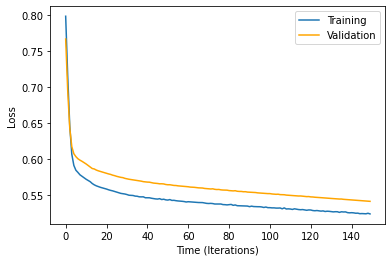

In [0]:
plt.plot(train_losses_avgs, label='Training')
plt.plot(validate_losses_avgs, color='orange', label='Validation')
plt.xlabel('Time (Iterations)')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
# Save model weights
path = F"drive/My Drive/Colab Notebooks/Big Data Capstone/fake-news-model.pt" 
#torch.save(model.state_dict(), path) # save model to drive
# Use the code below to load
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [0]:
from sklearn.metrics import confusion_matrix

correct = 0
total = 0
y_hat = []
y_true = []
with torch.no_grad():
    for x, targets in val_loader:
        x = x.cuda()
        targets = targets.cuda()
        prediction = model(x)
        _, predicted = torch.max(prediction.data, 1)
        for pred, target in zip(predicted, targets):
            y_hat.append(int(pred))
            y_true.append(int(target))
            total += 1
            if pred == target:
                correct += 1

cm = confusion_matrix(y_true, y_hat)
tn, fp, fn, tp = cm.ravel()
# recall = true positives / (true positives + false negatives)
# precision = true positives / (true positives + false positives)
print('Accuracy:', correct / total)
print('Recall:', tp / (tp + fn))
print('Precision:', tp / (tp + fp))

Accuracy: 0.7732558139534884
Recall: 0.5396825396825397
Precision: 0.7727272727272727


In [0]:
fp

10

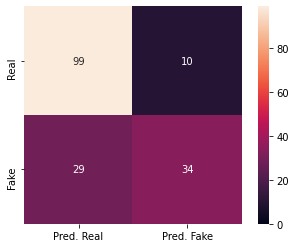

In [0]:
import seaborn as sns

df = pd.DataFrame(cm, index = ['Real', 'Fake'], columns= ['Pred. Real', 'Pred. Fake'])
sns.heatmap(df, square=True, annot=True, vmin=0)
plt.show()

## Article Headline/Text

In [0]:
# Probably don't even need this -- Danny
! pip install html2text
import html2text

In [0]:
def get_tags_as_string(html, tag, limit=None):
    page = bs4.BeautifulSoup(html, 'lxml')
    tags = page.find_all(name=tag)
    tags_strs = [tag.getText() for tag in tags]
    return '\n\n'.join(tags_strs[:limit])

In [0]:
h = html2text.HTML2Text()
h.ignore_links = True
response = requests.get('https://www.nbcnews.com/politics/congress/senate-passes-8-3-billion-emergency-bill-combat-coronavirus-n1150521', timeout=10)
print(get_tags_as_string(response.text, 'h1'))
print(get_tags_as_string(response.text, 'p'))

In [0]:
def get_header(url_str):
  if 'http://' in url_str:
    response = requests.get(url_str, timeout=10)
  else:
     response = requests.get('http://'+ url_str, timeout=10)
  return get_tags_as_string(response.text, 'h1')
def get_body(url_str):
  if 'http://' in url_str:
    response = requests.get(url_str, timeout=10)
  else:
     response = requests.get('http://'+ url_str, timeout=10)
  return get_tags_as_string(response.text, 'p')

In [0]:
from requests.exceptions import ConnectionError, ReadTimeout, TooManyRedirects
from urllib3.exceptions import NewConnectionError, MaxRetryError
headers = ['']*len(full_df['url'])
bodies = ['']*len(full_df['url'])
full_df['header'] = headers
full_df['body'] = bodies


In [0]:
for i in range(len(full_df['url'])):
  try:
    full_df['header'][i] = get_header(str(full_df['url'][i]))
    full_df['body'][i] = get_body(str(full_df['url'][i]))
  except (NewConnectionError, MaxRetryError, ConnectionError, ReadTimeout, TooManyRedirects):
    pass

## Articly Body Sentiment Analysis - Empath (Parker)

In [0]:
lexicon = Empath()
example = full_df['body'][2]
example = re.sub('\n|\r|\t',' ',example)
example_dict = lexicon.analyze(example, normalize=True)
col_names = []
for key in example_dict:
    col_names.append(key)
blank_dict = {}
for name in col_names:
    blank_dict[name] = 0.0
def create_sent_dict(body):
    x = re.sub('\n|\r|\t',' ',str(body))
    d = lexicon.analyze(x, normalize=True)
    if not bool(d):
        return blank_dict
    return d
sentiment_df = pd.DataFrame(columns = col_names)
# now we just need to merge sentiment_df and full_df for more features

## Next Steps

In [0]:
#full_df['header'] = headers
#full_df['body'] = bodies

In [0]:
# why do we have one more header than we have rows in full_df?

TODO:
1. Empath (for sentiment analysis) (Parker)
2. Header/Body agreement (Parker)
3. Dowload CSV, look at it in R (Romney)
4. Chrome Extension (Danny)


In [0]:
headers[len(headers)-2]

In [0]:
https://www.kaggle.com/cast42/lightgbm-model-explained-by-shap
face detection notebook from last semester